<a href="https://colab.research.google.com/github/JN-Nataraj/MACHINE-LEARNING/blob/main/01.%20Linear%20Regression/BigMart_Sales_Prediction_Linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import chi2

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
# By checking the shape we get to know how many features we have in our dataset
train.shape

(8523, 12)

In [ ]:
test.shape


(5681, 11)

In [ ]:
#Check if there are any null values in our training dataset
#train.isna().sum()

#to check which records has NAN value
#train[train.isna().any(axis=1)]

#to check which column has zero value
(train == 0).sum()


,0
Item_Identifier,0
Item_Weight,0
Item_Fat_Content,0
Item_Visibility,526
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,0
Outlet_Location_Type,0


<Axes: xlabel='Item_Outlet_Sales', ylabel='Count'>

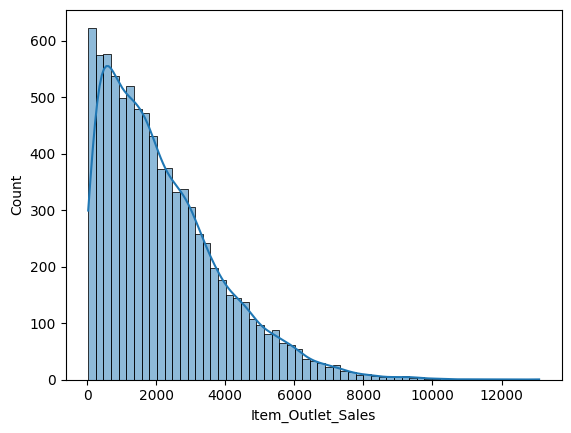

In [ ]:
sns.histplot(train['Item_Outlet_Sales'],kde = True)

In [ ]:
#train['Item_Outlet_Sales'].describe()
train['Item_Visibility'].describe()

,Item_Visibility
count,8523.000000
mean,0.066132
std,0.051598
min,0.000000
25%,0.026989
50%,0.053931
75%,0.094585
max,0.328391


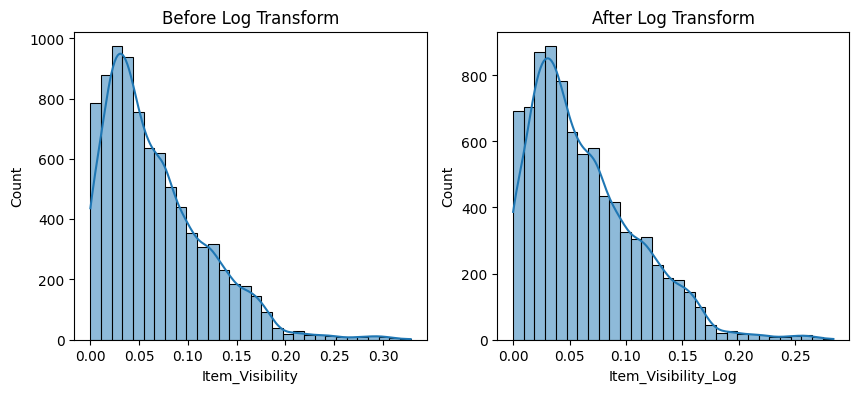

In [ ]:
train['Item_Visibility_Log'] = np.log1p(train['Item_Visibility'])

fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(train['Item_Visibility'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Before Log Transform')

sns.histplot(train['Item_Visibility_Log'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('After Log Transform')

plt.show()

In [ ]:
# @title
# sns.boxplot(train['Item_Visibility_Log'])
# sns.histplot(train['Item_Visibility'], bins=30, kde=True)
# plt.title("Distribution of Item Visibility")
# plt.show()
# Calculate mean and std
# mean = train['Item_Visibility'].mean()
# std = train['Item_Visibility'].std()

# # Plot with Seaborn
# plt.figure(figsize=(10,6))
# sns.histplot(train['Item_Weight'], bins=30, kde=True, color='skyblue')

# # Add mean and SD lines
# plt.axvline(mean, color='red', linestyle='--', linewidth=2, label=f'Mean = {mean:.2f}')
# plt.axvline(mean + std, color='green', linestyle='--', linewidth=1.5, label=f'+1 SD = {mean+std:.2f}')
# plt.axvline(mean - std, color='green', linestyle='--', linewidth=1.5, label=f'-1 SD = {mean-std:.2f}')
# plt.axvline(mean + 2*std, color='orange', linestyle=':', linewidth=1.5, label=f'+2 SD = {mean+2*std:.2f}')
# plt.axvline(mean - 2*std, color='orange', linestyle=':', linewidth=1.5, label=f'-2 SD = {mean-2*std:.2f}')

# # Labels
# plt.title('Item_Weight Distribution (with Mean & Standard Deviation)', fontsize=14)
# plt.xlabel('Item_Weight')
# plt.ylabel('Count')
# plt.legend()
# plt.grid(alpha=0.3)
# plt.show()

In [ ]:
num_cols = train.select_dtypes(include = np.number).columns.tolist()
num_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales',
 'Item_Visibility_Log']

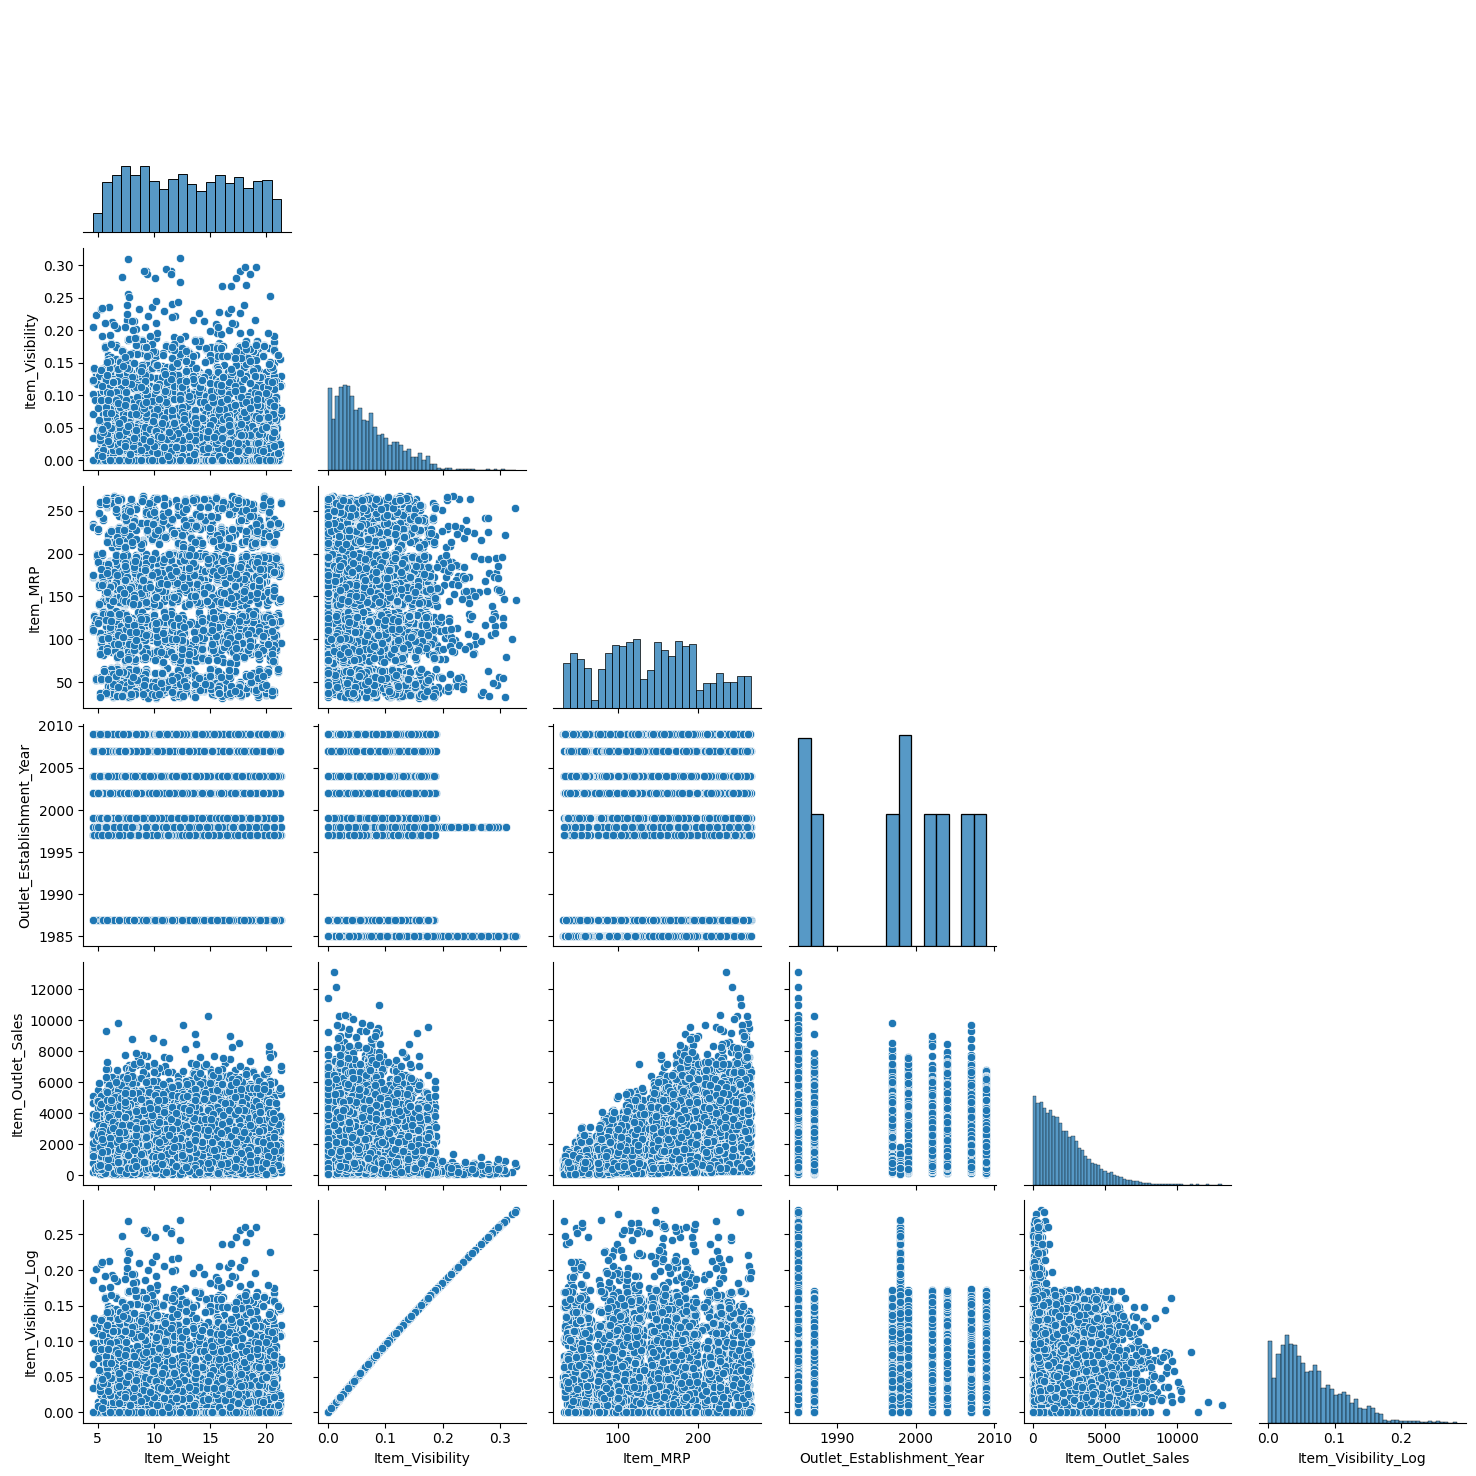

In [ ]:
sns.pairplot(train[num_cols],corner=True)

1. Strong linear relationship (MRP-Sales)
2. Weak relationships (visibility and weight vs Sales)
3. Distributions along the diagonal reveal right-skewness.. WE can do log-transformations before modelling for this..

Preprocessings:
1. LF - Regular fix
2. Itemweight - Missing values - MEan
3. Outlet_size - Missing values - Mode
4. Item_Visibility - fix 0s with Median

In [ ]:
CURRENT_YEAR = 2013
for df in [train, test]:
    # Standardize labels
    df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})

    # Fill missing Item_Weight values hierarchically
    # First, try to fill with the mean weight for the same Item_Identifier
    df['Item_Weight'] = df.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))
    # Then, for any remaining NaNs, fill with the mean weight for the same Item_Type
    df['Item_Weight'] = df.groupby('Item_Type')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))
    # # Finally, fill any last remaining NaNs with the global mean Item_Weight
    # df['Item_Weight'].fillna(df['Item_Weight'].mean(), inplace=True)

    #df['Item_Visibility'] = df['Item_Visibility'].replace(0, df['Item_Visibility'].median())
    df['Outlet_Size'].fillna(df['Outlet_Size'].mode()[0], inplace=True)

    df['Item_Category'] = df['Item_Identifier'].apply(lambda x: x[:2])
    df['Outlet_age'] = CURRENT_YEAR - df['Outlet_Establishment_Year']
    df['Visibility_MeanRatio'] = df['Item_Visibility'] / df['Item_Visibility'].mean()
    #Categorizing item visibility - Low / High
    df['Outlet_Location_Score'] = df['Outlet_Location_Type'].map({"Tier 1":1,"Tier 2":2,"Tier 3":3})
    df['High_MRP_Flag'] = (df['Item_MRP'] > df['Item_MRP'].median()).astype(int)

    df['MRP_bin'] = pd.qcut(df['Item_MRP'], q=10, duplicates='drop')
    medians = df.groupby('MRP_bin')['Item_Weight'].median()
    variation = medians.max() - medians.min()


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Item_Identifier            8523 non-null   object  
 1   Item_Weight                8523 non-null   float64 
 2   Item_Fat_Content           8523 non-null   object  
 3   Item_Visibility            8523 non-null   float64 
 4   Item_Type                  8523 non-null   object  
 5   Item_MRP                   8523 non-null   float64 
 6   Outlet_Identifier          8523 non-null   object  
 7   Outlet_Establishment_Year  8523 non-null   int64   
 8   Outlet_Size                8523 non-null   object  
 9   Outlet_Location_Type       8523 non-null   object  
 10  Outlet_Type                8523 non-null   object  
 11  Item_Outlet_Sales          8523 non-null   float64 
 12  Item_Visibility_Log        8523 non-null   float64 
 13  Item_Category              8523 n

In [ ]:


categorical_cols = train.select_dtypes(include=['object']).columns
for col in categorical_cols:
    medians = train.groupby(col)['Item_Weight'].median()
    variation = medians.max() - medians.min()
    print(f"{col} → median variation = {variation}")

medians = train.groupby('MRP_bin')['Item_Weight'].median()
variation = medians.max() - medians.min()
print(f"MRP_bin → median variation = {variation}")

Item_Identifier → median variation = 16.795
Item_Fat_Content → median variation = 0.3000000000000007
Item_Type → median variation = 4.602499999999999
Outlet_Identifier → median variation = 0.5500000000000007
Outlet_Size → median variation = 0.25
Outlet_Location_Type → median variation = 0.3000000000000007
Outlet_Type → median variation = 0.25
Item_Category → median variation = 1.299999999999999
MRP_bin → median variation = 1.325000000000001


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   Item_Identifier            8523 non-null   object  
 1   Item_Weight                8523 non-null   float64 
 2   Item_Fat_Content           8523 non-null   object  
 3   Item_Visibility            8523 non-null   float64 
 4   Item_Type                  8523 non-null   object  
 5   Item_MRP                   8523 non-null   float64 
 6   Outlet_Identifier          8523 non-null   object  
 7   Outlet_Establishment_Year  8523 non-null   int64   
 8   Outlet_Size                8523 non-null   object  
 9   Outlet_Location_Type       8523 non-null   object  
 10  Outlet_Type                8523 non-null   object  
 11  Item_Outlet_Sales          8523 non-null   float64 
 12  Item_Visibility_Log        8523 non-null   float64 
 13  Item_Category              8523 n

In [ ]:
num_cols = train.select_dtypes(include = np.number).columns.tolist()
num_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales',
 'Item_Visibility_Log',
 'Outlet_age',
 'Visibility_MeanRatio',
 'Outlet_Location_Score',
 'High_MRP_Flag']

1. Ratios & interaction proportions
2. Aggregated Statistical Features
3. Non-Linear Transformations #optional
4. Encoding

In [ ]:
train[num_cols].corr()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Visibility_Log,Outlet_age,Visibility_MeanRatio,Outlet_Location_Score,High_MRP_Flag
Item_Weight,1.000000,-0.009215,0.025967,-0.013417,0.013198,-0.009083,0.013417,-0.009215,0.002973,0.024840
Item_Visibility,-0.009215,1.000000,-0.001315,-0.074834,-0.128625,0.999410,0.074834,1.000000,-0.028099,0.006393
Item_MRP,0.025967,-0.001315,1.000000,0.005020,0.567574,-0.000701,-0.005020,-0.001315,0.000232,0.843347
Outlet_Establishment_Year,-0.013417,-0.074834,0.005020,1.000000,-0.049135,-0.072349,-1.000000,-0.074834,-0.089216,-0.005651
Item_Outlet_Sales,0.013198,-0.128625,0.567574,-0.049135,1.000000,-0.125600,0.049135,-0.128625,0.089367,0.485460
Item_Visibility_Log,-0.009083,0.999410,-0.000701,-0.072349,-0.125600,1.000000,0.072349,0.999410,-0.027210,0.006329
Outlet_age,0.013417,0.074834,-0.005020,-1.000000,0.049135,0.072349,1.000000,0.074834,0.089216,0.005651
Visibility_MeanRatio,-0.009215,1.000000,-0.001315,-0.074834,-0.128625,0.999410,0.074834,1.000000,-0.028099,0.006393
Outlet_Location_Score,0.002973,-0.028099,0.000232,-0.089216,0.089367,-0.027210,0.089216,-0.028099,1.000000,-0.004603
High_MRP_Flag,0.024840,0.006393,0.843347,-0.005651,0.485460,0.006329,0.005651,0.006393,-0.004603,1.000000


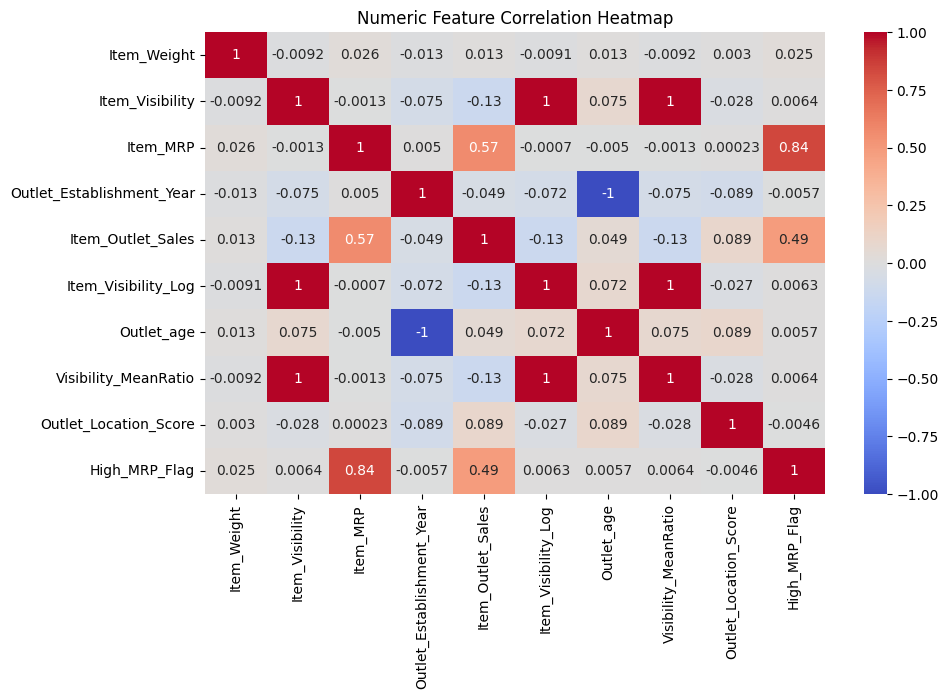

In [ ]:
# Correlation heatmap (numeric features) Pearson Coefficent
num_cols = train.select_dtypes(include=np.number).columns.tolist()
plt.figure(figsize=(10,6))
sns.heatmap(train[num_cols].corr(), cmap='coolwarm', annot=True)
plt.title("Numeric Feature Correlation Heatmap")
plt.show()

In [ ]:
# Chi-square test for categorical vs target
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

cat_cols = train.select_dtypes(exclude=np.number).columns
chi_results = []

#Chi-Square is a test for variance
for c in cat_cols:
    contingency = pd.crosstab(train[c], pd.qcut(train["Item_Outlet_Sales"], q=4)) #4Quartilee
    chi2_stat, p, dof, ex = chi2_contingency(contingency)
    chi_results.append((c, chi2_stat, p))
    #H0 - No association between each categorical variable and binned sales
    #HA - Strong Relationship (p<0.05) reject Null
chi_df = pd.DataFrame(chi_results, columns=["Feature","Chi2","p_value"]).sort_values("p_value")
print("Chi-Square association with Item_Outlet_Sales (lower p = stronger association):")
display(chi_df)

Chi-Square association with Item_Outlet_Sales (lower p = stronger association):


,Feature,Chi2,p_value
3,Outlet_Identifier,3679.210196,0.000000e+00
6,Outlet_Type,3647.922343,0.000000e+00
8,MRP_bin,3584.818785,0.000000e+00
0,Item_Identifier,7454.138969,1.486821e-132
5,Outlet_Location_Type,282.177067,5.372026e-58
4,Outlet_Size,119.632597,1.946431e-23
7,Item_Category,27.515132,1.159189e-04
2,Item_Type,88.372933,1.204309e-04
1,Item_Fat_Content,5.429388,1.429235e-01


In [ ]:
target = "Item_Outlet_Sales"

features = ["Item_Weight",'Item_Visibility','Item_MRP','Outlet_age','Outlet_Location_Score','Item_Type','Item_Category',
            'Outlet_Size','Outlet_Location_Type','Outlet_Type','Outlet_Identifier']

X = train[features]
y = train[target]

X_test = test[features]

num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

In [ ]:
preprocessor = ColumnTransformer([("num",StandardScaler(),num_cols),
                                  ("cat", OneHotEncoder(handle_unknown="ignore", drop='first',sparse_output=False),cat_cols)])
lin_pipe = Pipeline([('prep',preprocessor),
                     ('model',LinearRegression())])

In [ ]:
lin_pipe.fit(X,y) #Gradient descent is happening here..!
y_pred = lin_pipe.predict(X)

In [ ]:
r2 = r2_score(y,y_pred)
print(f"R2 Score: {r2}")

R2 Score: 0.5636591382477865


In [ ]:
rmse

np.float64(1127.180995929913)

In [ ]:
preds = lin_pipe.predict(X_test)
preds = np.clip(preds,0,None)

submission = pd.DataFrame({'Item_Identifier':test['Item_Identifier'],
                           'Outlet_Identifier':test['Outlet_Identifier'],
                           'Item_Outlet_Sales': preds})

submission.to_csv("Submission_LR_CF.csv",index=False)
